`pace-python` is a Python module which packages together "compiled" versions of the Matlab programs which comprises the PACE suite of inelastic neutron scattering data analysis programs.
It includes [Horace](https://github.com/pace-neutrons/Horace) and [SpinW](https://github.com/SpinW/SpinW) and interfaces between these programs and other PACE components such as [Euphonic](https://github.com/pace-neutrons/euphonic) and [Brille](https://github.com/brille/brille).

This notebook is an example of how to use `pace-python`.

At the moment you have to compile `pace-python` using:

```
git clone https://github.com/pace-neutrons/pace-python
cd pace-python
cmake .
cmake --build .
```

Then start this notebook. The next cell imports the `pace_python` module and starts the Matlab interpreter which is assigned as to the variable `m`.
All calls to Horace/SpinW methods are called as methods of `m`: you need to prefix such calls with `m.` as shown below.

In [1]:
from pace_neutrons import Matlab
m = Matlab()

Found: C:\Program Files\MATLAB\R2020b\runtime\win64;C:\Program Files\MATLAB\R2020b\bin
Interface opened


Usually Matlab plots appear in separate windows, but with Jupyter notebooks it is more usual to have them appear as pictures inside the notebook.
This behaviour can be changed with a "magic" function, `%pace_python`:

You can get help on it using:

In [2]:
%pace?

By default the `'inline'` option is used with a 400x300@150 dpi figure. We will change that to 100 dpi:

In [3]:
%pace inline -r 100

The following cell demostrates a simple cut.

The dataset used here is publically available on [zenodo/4088240](https://zenodo.org/record/4088240) as an archive [data_generation.tar.gz](https://zenodo.org/record/4088240/files/data_generation.tar.gz?download=1). Alternatively you could use your own data in `.sqw` format.

In [4]:
# For this demo we keep only reduced data cuts from a larger dataset
# The cuts were generated using:
#
# proj = m.projaxes([1, 0, 0], [0, 1, 0], 'type', 'rrr')
# w1 = m.cut_sqw('datafiles/pcsmo_ei70_base_bkd.sqw', proj, [-1, 0.05, 1], [-1, 0.05, 1], [], [10, 0.5, 20])
# w1.save('datafiles/pcsmo_cut1.sqw')
# w2 = m.cut_sqw('pcsmo_ei70_base_bkd.sqw', proj, [-1, 0.05, 1], [-0.2, 0.2], [], [5, 0.5, 65])
# w2.save('datafiles/pcsmo_cut2.sqw')

 The configuration has been set to defaults. Type:
>>parallel_config
   to check if defaults are correct
> In get_config_ (line 49)
In config_store/get_config (line 275)
In config_store/get_config_field (line 116)
In config_base/get_or_restore_field (line 151)
In parallel_config.get.working_directory (line 264)
In PixelTmpFileHandler/generate_tmp_dir_path_ (line 209)
In PixelTmpFileHandler (line 26)
In PixelData/init_from_file_accessor_ (line 776)
In PixelData (line 371)
In sqw_binfile_common/get_data (line 129)
In sqw_binfile_common/get_sqw (line 98)
In sqw/get_loader_struct_ (line 211)
In sqw (line 81)
In cut>obj_from_faccessor (line 46)
In cut (line 17)
In cut_sqw (line 31)
In call_method (line 100)
Step   1 of   1; Read data for 257683 pixels -- processing data... ----->  retained  234060 pixels


array([], shape=(0, 0), dtype=float64)

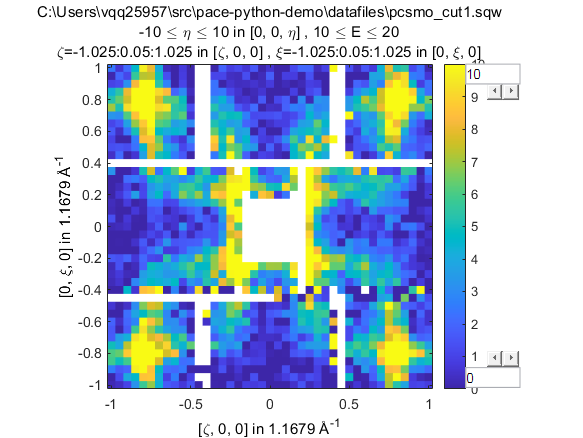

In [5]:
proj = m.projaxes([1, 0, 0], [0, 1, 0], 'type', 'rrr')
w1 = m.cut_sqw('datafiles/pcsmo_cut1.sqw', proj, [-1, 0.05, 1], [-1, 0.05, 1], [-10, 10], [10, 20], '-nopix')
w1.plot()
m.lz(0, 10)

We can also make a cut within a cut. Note the absence of the `'-nopix'` option, which keeps all the pixels in the cut `w2`, allowing us to cut it again.
With the `'-nopix'` option, the output workspace (`w1`) has only the rebinned data, and the original pixels are discarded.

We then make a cut of the data in `w2` to produce `w3` using the `'-nopix'` option since we don't want to make further cuts of the data from `w3`.

Note that in the original `w2` cut we have to provide the data file name, the projection, and 4 binning parameters for each of the 4 axes $(Q_h, Q_k, Q_l, \hbar\omega)$.
In contrast in making the cut `w3` we only provide 2 binning parameters because `w2` is a 2D object and we know the data source and projection.

We can then see below that `w3` is of a `d2d` type (without pixel information), whilst `w2` is an `sqw` type (with pixel information)

Finally, note we use a variant of the `plot` command. Previously we used `w1.plot()` but `m.plot(w1)` is equivalent and works the same.

Step   1 of   1; Read data for 636602 pixels -- processing data... ----->  retained  636600 pixels


array([], shape=(0, 0), dtype=float64)

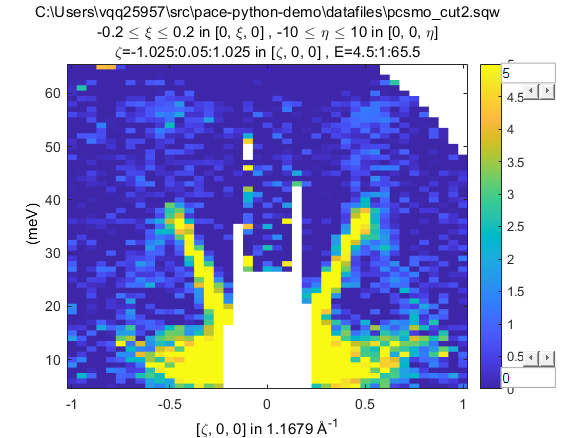

In [6]:
w2 = m.cut_sqw('datafiles/pcsmo_cut2.sqw', proj, [-1, 0.05, 1], [-0.2, 0.2], [-10, 10], [5, 1, 65])
m.plot(w2)
m.lz(0, 5)

Step   1 of   1; Read data for 57712 pixels -- processing data... ----->  retained  38812 pixels
The type of w2 is: sqw
The type of w3 is: d1d


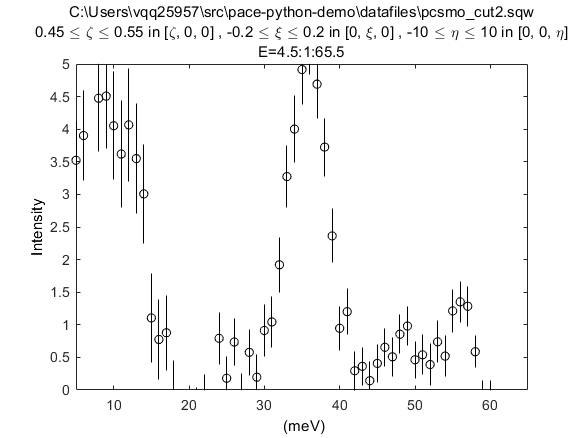

In [7]:
m.acolor('black')
w3 = w2.cut([0.45, 0.55], [5, 1, 65], '-nopix')
m.plot(w3)
m.ly(0, 5)

print(f'The type of w2 is: {m.type(w2)}')
print(f'The type of w3 is: {m.type(w3)}')

The next example is more complicated and involves computing a theoretical spectrum from a user defined model.

The model is that for spin waves in bcc-iron, and is defined as a Python function.

First we make a cut of a measurement of excitations in iron, and then simulate a spectra on the q-points covered in this cut.

We then define the model as a Python function and evaluate the model.

Step   1 of   1; Read data for 32960 pixels -- processing data... ----->  retained  13190 pixels


<proxy for Matlab matlab.ui.Figure object>

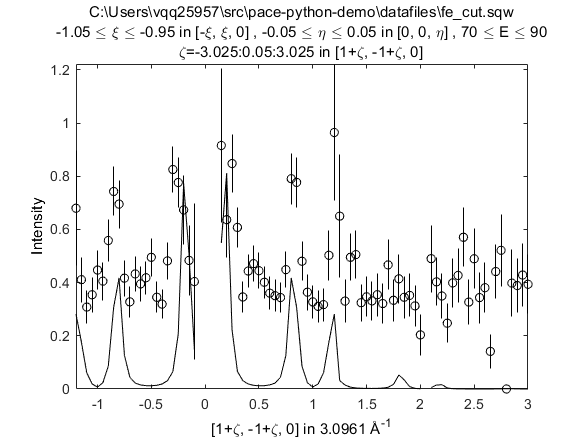

In [8]:
# Make a cut of the data
proj = {'u':[1,1,0], 'v':[-1,1,0], 'type':'rrr'}
energy_range = range(80, 160, 20)
w_fe = m.cut_sqw('datafiles/fe_cut.sqw', proj, [-3,0.05,3], [-1.05,-0.95], [-0.05,0.05], [70, 90])

# Parameters for the form factor of Fe2+
A=0.0706; a=35.008;  B=0.3589; b=15.358;  C=0.5819; c=5.561;  D=-0.0114;

# Define the Python function
import numpy as np
def py_fe_sqw(h, k, l, e, p):
    js = p[0]
    d = p[1]
    om = d + (8*js) * (1 - np.cos(np.pi * h) * np.cos(np.pi * k) * np.cos(np.pi * l))
    q2 = ((1/(2*2.87))**2) * (h**2 + k**2 + l**2)
    ff = A * np.exp(-a*q2) + B * np.exp(-b*q2) + C * np.exp(-c*q2) + D
    return (ff**2) * (p[4]/np.pi) * (e / (1-np.exp(-11.602*e/p[3]))) * (4 * p[2] * om) / ((e**2 - om**2)**2 + 4*(p[2] * e)**2)

# Starting parameters for fit
J = 35;     # Exchange interaction in meV
D = 0;      # Single-ion anisotropy in meV
gam = 30;   # Intrinsic linewidth in meV (inversely proportional to excitation lifetime)
temp = 10;  # Sample measurement temperature in Kelvin
amp = 300;  # Magnitude of the intensity of the excitation (arbitrary units)

# Evaluate the mode on the cut with the starting parameters
w_cal = m.sqw_eval(w_fe, py_fe_sqw, [J, D, gam, temp, amp])

# Plots the data and model together
m.plot(w_fe)
m.pl(w_cal)

We now try to fit the data in the cut with the model.

For the fit, we also add a linear background. We use the `linear_bg` function built into Horace, but this is Matlab function so, we need to call `eval` to obtain an anonymous handle to it.

In the `fit` call we specify the `'comp'` option which means that it returns a `dict` with separate components, `fore` (the foreground fit function), `back` (the linear background) and `sum` (the total). We'll then plot the `sum` and `back` components on top of the data.


mess =

  1x2 cell array

    {'Dataset:'}    {'1 points with zero, negative or undefined (infinite or NaN) error bars have be...'}


mess =

    'Dataset:1 points with zero, negative or undefined (infinite or NaN) error bars have been removed from fit, which is 0.82645 % of the number of points in this dataset'

> In mask_data_for_fit (line 46)
In mfclass/fit (line 118)
In mfclass_Horace_sqw/fit (line 822)
In call_method (line 102)
--------------------------------------------------------------------------------
Beginning fit (max 20 iterations)--------------------------------------------------------------------------------
Starting point
------------------
 Total time = 0.040033s    Reduced Chi^2 = 13.0961
 Free parameter values:
            35             30            300            0.1  
--------------------------------------------------------------------------------
Iteration = 1
------------------
 Total time = 0.1404s    Reduced Chi^2 = 1.6672      Levenberg-Marquardt = 0.1
 Fr

<proxy for Matlab matlab.ui.Figure object>

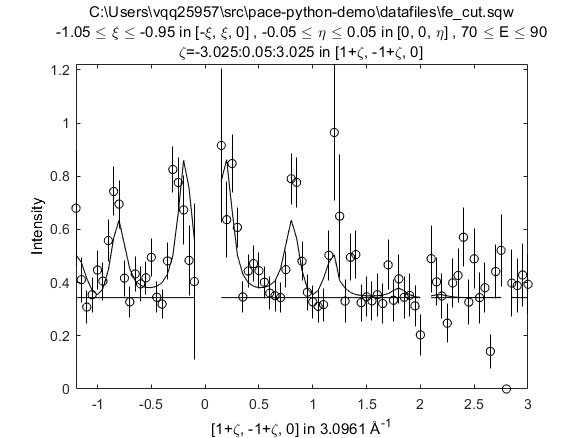

In [9]:
# Define linear background function
linear_bg = m.eval('@linear_bg')

kk = m.multifit_sqw(w_fe)
kk = kk.set_fun (py_fe_sqw, [J, D, gam, temp, amp])
kk = kk.set_free ([1, 0, 1, 0, 1])
kk = kk.set_bfun (linear_bg, [0.1,0])
kk = kk.set_bfree ([1,0])
kk = kk.set_options ('list',2)

# Run and time the fit
m.tic()
wfit, fitdata = kk.fit('comp')
t_ana = m.toc();
print(f'Time to run fit: {t_ana}s')

# Plot it
m.plot(w_fe)
m.pl(wfit['sum'])
m.pl(wfit['back'])

We now turn to an example with the `spinw` package to calculate spin waves. 
We will reuse the bcc-iron dataset, but instead of a simple dispersion calculated in a Python function, we define a SpinW model for it.
While SpinW is more flexible, it is *much* more computationally intensive than the analytic model used before.

For more information on the syntax of SpinW, please see the [tutorials](https://spinw.org/tutorials/) and [documentation](https://spinw.org/SWclass/).
These are in Matlab syntax but the syntax here in Python is fairly similar, with some exceptions:

* Constructors (like in `fe = m.spinw()`) require an explicit brackets (so `fe = m.spinw` will not work).
* Matlab functions like `diag` must be preceded by `m.` and array elements needs `,` comma separators.
* `.T` is used for transposed in `numpy` instead of the `'` operator.

Creating the bond list (maxDistance = 8 , nCell = 3x3x3)...
...168 bonds are retained out of 784 generated!
Creating 3D plot... 
> In swplot.figure (line 142)
In swplot.activefigure (line 71)
In spinw/plot (line 150)
In call_method (line 100)
...18k faces and 11k vertices are drawn!


<proxy for Matlab matlab.ui.Figure object>

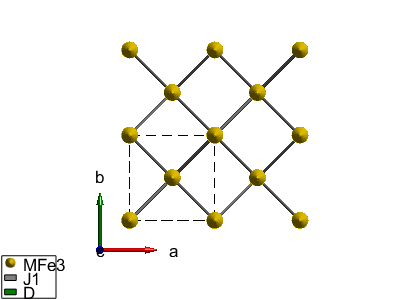

In [10]:
a = 2.87;

fe = m.spinw();
fe.genlattice('lat_const', [a, a, a], 'angled', [90, 90, 90], 'spgr', 'I m -3 m')  # bcc Fe
fe.addatom('label', 'MFe3', 'r', [0, 0, 0], 'S', 5/2, 'color', 'gold')
fe.gencoupling()
fe.addmatrix('label', 'J1', 'value', 1, 'color', 'gray')
fe.addmatrix('label', 'D', 'value', m.diag([0, 0, -1]), 'color', 'green')
fe.addcoupling('mat', 'J1', 'bond', 1)
fe.addaniso('D')
fe.genmagstr('mode', 'direct', 'S', np.array([[0., 0., 1.], [0., 0., 1.]]).T);  # Ferromagnetic

# Plots the structure
m.plot(fe, 'range', [2, 2, 2])

Once we define the SpinW model, we can evaluate it just like before, using the `.horace_sqw` gateway method of the `spinw` object.

First we need to define some parameters for the spectrum evaluation.
These are not defined in the model above because they are specific to the calculation of the spectrum and not of the model itself.
They are essentially the same options which go to `fe.spinwave()` when called normally in SpinW.


mess =

  1x2 cell array

    {'Dataset:'}    {'1 points with zero, negative or undefined (infinite or NaN) error bars have be...'}


mess =

    'Dataset:1 points with zero, negative or undefined (infinite or NaN) error bars have been removed from fit, which is 0.82645 % of the number of points in this dataset'

> In mask_data_for_fit (line 46)
In mfclass/simulate (line 136)
In mfclass_Horace_sqw/simulate (line 727)
In call_method (line 102)
Calculating COMMENSURATE spin wave spectra (nMagExt = 2, nHkl = 13184)...
The magnetic form factor is included in the calculated structure factor.
No g-tensor is included in the calculated structure factor.
Calculation finished.
Time to evaluate a single iteration: 0.5778883s


<proxy for Matlab matlab.ui.Figure object>

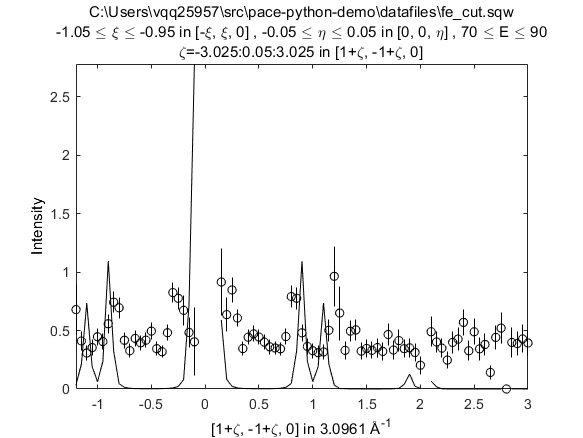

In [11]:
# Constant parameters for SpinW model
# Note that we use the damped harmonic oscillator resolution model ('sho')
cpars = ['mat', ['J1', 'D(3,3)'], 'hermit', False, 'optmem', 1,
         'useFast', True, 'resfun', 'sho', 'formfact', True];

kk = m.multifit_sqw(w_fe)
kk = kk.set_fun (fe.horace_sqw, [[J, D, gam, temp, amp]]+cpars)
kk = kk.set_free ([1, 0, 1, 0, 1]);
kk = kk.set_bfun (linear_bg, [0.1,0]);
kk = kk.set_bfree ([1,0]);
kk = kk.set_options ('list',2);

# Time a single iteration
m.tic()
wsim = kk.simulate('comp');
t_spinw_single = m.toc();

print(f'Time to evaluate a single iteration: {t_spinw_single}s')

m.plot(w_fe)
m.pl(wsim['fore'])

We see that a single iteration with SpinW takes longer than the full fitting with the analytic function.

We now try the fit, and see how long it takes and how well it works.

In [12]:
# Time the fit
m.tic()
wfit, fitdata = kk.fit('comp');
t_spinw = m.toc();


mess =

  1x2 cell array

    {'Dataset:'}    {'1 points with zero, negative or undefined (infinite or NaN) error bars have be...'}


mess =

    'Dataset:1 points with zero, negative or undefined (infinite or NaN) error bars have been removed from fit, which is 0.82645 % of the number of points in this dataset'

> In mask_data_for_fit (line 46)
In mfclass/fit (line 118)
In mfclass_Horace_sqw/fit (line 822)
In call_method (line 102)
--------------------------------------------------------------------------------
Beginning fit (max 20 iterations)Calculating COMMENSURATE spin wave spectra (nMagExt = 2, nHkl = 13184)...
The magnetic form factor is included in the calculated structure factor.
No g-tensor is included in the calculated structure factor.
Calculation finished.
--------------------------------------------------------------------------------
Starting point
------------------
 Total time = 0.36167s    Reduced Chi^2 = 19.6173
 Free parameter values:
            35             30 

Calculation finished.
Calculating COMMENSURATE spin wave spectra (nMagExt = 2, nHkl = 13184)...
The magnetic form factor is included in the calculated structure factor.
No g-tensor is included in the calculated structure factor.
Calculation finished.
Calculating COMMENSURATE spin wave spectra (nMagExt = 2, nHkl = 13184)...
The magnetic form factor is included in the calculated structure factor.
No g-tensor is included in the calculated structure factor.
Calculation finished.
Calculating COMMENSURATE spin wave spectra (nMagExt = 2, nHkl = 13184)...
The magnetic form factor is included in the calculated structure factor.
No g-tensor is included in the calculated structure factor.
Calculation finished.
 Total time = 9.3082s    Reduced Chi^2 = 4.276      Levenberg-Marquardt = 0.0001
 Free parameter values:
         11.63          -1580          97.42         0.3388  
Calculating COMMENSURATE spin wave spectra (nMagExt = 2, nHkl = 13184)...
The magnetic form factor is included in the calcul

Time for SpinW fit = 14.7531779s


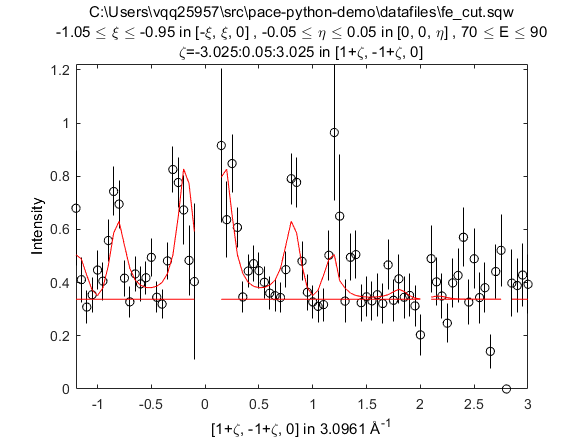

In [13]:
print(f'Time for SpinW fit = {t_spinw}s')

m.acolor('black');
hf3 = m.plot(w_fe);
m.acolor('red');
m.pl(wfit['sum']);
m.pl(wfit['back']);

# TODO: Print out fitted values and errors


mess =

  1x2 cell array

    {'Dataset:'}    {'1 points with zero, negative or undefined (infinite or NaN) error bars have be...'}


mess =

    'Dataset:1 points with zero, negative or undefined (infinite or NaN) error bars have been removed from fit, which is 0.82645 % of the number of points in this dataset'

> In mask_data_for_fit (line 46)
In mfclass/simulate (line 136)
In mfclass_Horace_sqw/simulate (line 727)
In call_method (line 102)
Calculating COMMENSURATE spin wave spectra (nMagExt = 2, nHkl = 13184, nTwin = 1)...
Creating Brille grid
Filling Brille grid
Calculating COMMENSURATE spin wave spectra (nMagExt = 2, nHkl = 48230, nTwin = 1)...
No magnetic form factor is included in the calculated structure factor.
No g-tensor is included in the calculated structure factor.
Calculation finished.
The magnetic form factor is included in the calculated structure factor.
No g-tensor is included in the calculated structure factor.
Calculation finished.
Time to fill Brille grid: 20.450

<proxy for Matlab matlab.ui.Figure object>

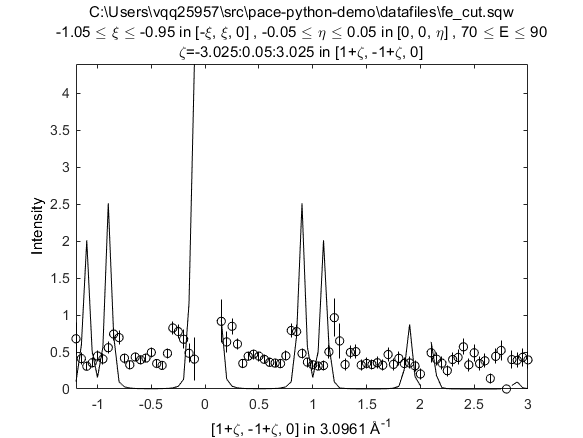

In [14]:
# Run through it again using Brille
cpars = ['mat', ['J1', 'D(3,3)'], 'hermit', False, 'optmem', 1,
         'useFast', False, 'resfun', 'sho', 'formfact', True, 'use_brille', True];

kk = m.multifit_sqw(w_fe)
kk = kk.set_fun (fe.horace_sqw, [[J, D, gam, temp, amp]]+cpars)
kk = kk.set_free ([1, 0, 1, 0, 1]);
kk = kk.set_bfun (linear_bg, [0.1,0]);
kk = kk.set_bfree ([1,0]);
kk = kk.set_options ('list',2);

# Time a single iteration
m.tic()
wsim = kk.simulate('comp');
t_spinw_fill = m.toc();

print(f'Time to fill Brille grid: {t_spinw_fill}s')

m.tic()
wsim = kk.simulate('comp');
t_spinw_single = m.toc();

print(f'Time to evaluate a single iteration: {t_spinw_single}s')

m.acolor('k')
m.plot(w_fe)
m.pl(wsim['fore'])

Finally we end with an example of using Euphonic to evaluate spectrum from a phonon DFT calculation.

Euphonic is a Python package so we have to install it first.
You can do this using `pip` (`pip install euphonic[phonopy_reader]`).
We also use an interface package, `euphonic_sqw_models` but this is installed directly by `pace_python`.

First we load a DFT calculation into a Euphonic `ForceConstants` object.
This is the basic Euphonic object and most functionalities of Euphonic is accessible from this object.
For more information, please see the [documentation](https://euphonic.readthedocs.io).

From the `ForceConstants` object we create a `CoherentCrystal` object which is what we will use to simulate the neutron spectrum.
The `CoherentCrystal` object acts as an interface between Horace and Euphonic and provides a gateway method, `.horace_disp` which is passed to the Horace `disp2sqw_eval` function.


Step   1 of   1; Read data for 19509 pixels -- processing data... ----->  retained  15395 pixels
Using Euphonic to interpolate for q-points 0:10000 out of 15395
Using Euphonic to interpolate for q-points 10000:15395 out of 15395


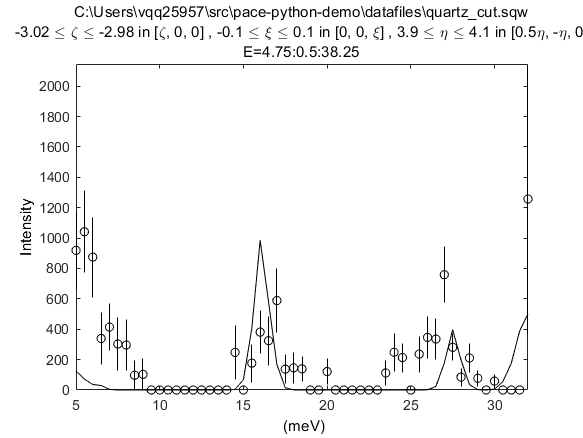

In [15]:
from euphonic import ForceConstants
from euphonic_sqw_models import CoherentCrystal

fc = ForceConstants.from_castep('datafiles/quartz.castep_bin')
euobj = CoherentCrystal(fc, debye_waller_grid=[6, 6, 6], temperature=100,
                        negative_e=True, asr=True, chunk=10000, use_c=True)

scalefac = 200
effective_fwhm = 1
intrinsic_fwhm = 0.1

wsc = m.cut_sqw('datafiles/quartz_cut.sqw', [-3.02, -2.98], [5, 0.5, 38])

# Calculate spectra with simple energy convolution (fixed width Gaussian)
wsim = m.disp2sqw_eval(wsc, euobj.horace_disp, (scalefac), effective_fwhm)

m.acolor('black')
hf = m.plot(wsc); m.pl(wsim);

Finally, we can repeat the simulation above but using the full instrument resolution calculation using the `tobyfit` method of Horace

In [ ]:
# Calculate spectra with full instrument resolution convolution
is_crystal = True;
xgeom = [0,0,1];
ygeom = [0,1,0];
shape = 'cuboid';
shape_pars = [0.01,0.05,0.01];
wsc = m.set_sample(wsc, m.IX_sample(is_crystal, xgeom, ygeom, shape, shape_pars));
ei = 40; freq = 400; chopper = 'g';
wsc = m.set_instrument(wsc, m.merlin_instrument(ei, freq, chopper));
disp2sqwfun = m.eval('@disp2sqw');
kk = m.tobyfit(wsc);
kk = kk.set_fun(disp2sqwfun, [euobj.horace_disp, [scalefac], intrinsic_fwhm]);
wtoby = kk.simulate()

hf = m.plot(wsc); m.pl(wsim); m.acolor('red'); m.pl(wtoby);